In [ ]:
import cv2
import json
from google.colab.patches import cv2_imshow
from datetime import datetime
from matplotlib import pyplot as plt
import numpy as np
import math
from PIL import Image
import os
import pandas as pd

In [ ]:
#video from camera starts with 760 width 428 height
def video_to_frame_arr(video_path):
  cap = cv2.VideoCapture(video_path)
  frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
  max_frame = frame_count
  output_arr = []
  # naive version (took 24s just appending frames)
  success, img = cap.read()
  while max_frame >= 0:
    max_frame = max_frame - 1
    output_arr.append(img)
    # read next frame
    success, img = cap.read()
  return output_arr

In [ ]:
def get_keypoints_descriptors(image):
  # Reading the image and converting into B/W
  #image = cv2.imread(image_path)
  gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  # Applying the function
  sift = cv2.xfeatures2d.SIFT_create()
  kp, des = sift.detectAndCompute(gray_image, None)
    
  # uncomment to draw keypoints on image
  #kp_image = cv2.drawKeypoints(image, kp, None, color=(
      #0, 255, 0)
      #, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
  
  return(kp, des)

In [ ]:
def feature_matching(des, des2):
  FLANN_INDEX_KDTREE = 1
  index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
  search_params = dict(checks = 50)
  flann = cv2.FlannBasedMatcher(index_params, search_params)
  matches = flann.knnMatch(des,des2,k=2)
  # store all the good matches as per Lowe's ratio test.
  good = []
  for m,n in matches:
      if m.distance < 0.7*n.distance:
          good.append(m)
  return good

In [ ]:
def get_homography_matrix(image, image2, kp, kp2, good, MIN_MATCH_COUNT):
  if len(good)>MIN_MATCH_COUNT:
      src_pts = np.float32([ kp[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
      dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
      M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
      matchesMask = mask.ravel().tolist()
      h = image.shape[0]
      w = image.shape[1]
      pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
      dst = cv2.perspectiveTransform(pts,M)
      #image2_lines = cv2.polylines(image2,[np.int32(dst)],True,255,3, cv2.LINE_AA)
  else:
      print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
      matchesMask = None
      M = []
  return M
#uncomment this if you want to circle the RANSAC inliers/outliers and how they connect between the images
"""
  draw_params = dict(matchColor = (0,255,0), # draw matches in green 
                    singlePointColor = None,
                    matchesMask = matchesMask, # draw only inliers
                    flags = cv2.DrawMatchesFlags_DEFAULT) #flags was 2
  image3 = cv2.drawMatches(image,kp,image2,kp2,good,None,**draw_params)
"""

'\n  draw_params = dict(matchColor = (0,255,0), # draw matches in green \n                    singlePointColor = None,\n                    matchesMask = matchesMask, # draw only inliers\n                    flags = cv2.DrawMatchesFlags_DEFAULT) #flags was 2\n  image3 = cv2.drawMatches(image,kp,image2,kp2,good,None,**draw_params)\n'

In [ ]:
#this is the same as get_homography_matrix but it also returns a side by side of the two images with RANSAC inliers/outliers circled and the inliers connected between images
def get_homography_matrix_old(image, image2, kp, kp2, good, MIN_MATCH_COUNT):
  if len(good)>MIN_MATCH_COUNT:
      src_pts = np.float32([ kp[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
      dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
      M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
      matchesMask = mask.ravel().tolist()
      h = image.shape[0]
      w = image.shape[1]
      pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
      dst = cv2.perspectiveTransform(pts,M)
      #image2_lines = cv2.polylines(image2,[np.int32(dst)],True,255,3, cv2.LINE_AA)
  else:
      print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
      matchesMask = None
      M = []
  draw_params = dict(matchColor = (0,255,0), # draw matches in green 
                    singlePointColor = None,
                    matchesMask = matchesMask, # draw only inliers
                    flags = cv2.DrawMatchesFlags_DEFAULT) #flags was 2
  image3 = cv2.drawMatches(image,kp,image2,kp2,good,None,**draw_params)
  return M, image3

In [ ]:
def warpTwoImages(img1, img2, H):
    '''warp img2 to img1 with homography matrix H'''
    h1,w1 = img1.shape[:2]
    h2,w2 = img2.shape[:2]
    pts1 = np.float32([[0,0],[0,h1],[w1,h1],[w1,0]]).reshape(-1,1,2)
    pts2 = np.float32([[0,0],[0,h2],[w2,h2],[w2,0]]).reshape(-1,1,2)
    pts2_ = cv2.perspectiveTransform(pts2, H)
    pts = np.concatenate((pts1, pts2_), axis=0)
    [xmin, ymin] = np.int32(pts.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(pts.max(axis=0).ravel() + 0.5)
    t = [-xmin,-ymin]
    Ht = np.array([[1,0,t[0]],[0,1,t[1]],[0,0,1]]) # translate

    result = cv2.warpPerspective(img2, Ht.dot(H), (xmax-xmin, ymax-ymin))
    result[t[1]:h1+t[1],t[0]:w1+t[0]] = img1
    return result

In [ ]:
#save array of frames to video 
def save_to_video(output_frame_arr, fps):
  height,width,layers=output_frame_arr[0].shape
  video=cv2.VideoWriter(filename = '/content/interval_five_later.avi',fourcc = 0,fps = fps,frameSize = (760, 428))
  for j in range(len(output_frame_arr)):
    video.write(output_frame_arr[j])
  video.release()

In [ ]:
#resize all frames in an array to the same resolution (specify desired width and height as parameters)
def resize_all(pano_frames_arr, width, height):
  resized_pano_arr = []
  height,width,layers=pano_frames_arr[0].shape
  for i in range(len(pano_frames_arr)):
    resized_pano_arr.append(cv2.resize(pano_frames_arr[i], (width, height)))
  return resized_pano_arr

In [ ]:
#given two frames, this function warps them to the same plane and translates them to their proper position on a shared background by adding padding where needed
#You need to use this if you don't want the final panorama to be cropped to the resolution of one of the original frames
def warpPerspectivePadded(src, dst, transf):

    src_h, src_w = src.shape[:2]
    lin_homg_pts = np.array([[0, src_w, src_w, 0], [0, 0, src_h, src_h], [1, 1, 1, 1]])

    trans_lin_homg_pts = transf.dot(lin_homg_pts)
    trans_lin_homg_pts /= trans_lin_homg_pts[2,:]

    minX = np.min(trans_lin_homg_pts[0,:])
    minY = np.min(trans_lin_homg_pts[1,:])
    maxX = np.max(trans_lin_homg_pts[0,:])
    maxY = np.max(trans_lin_homg_pts[1,:])

    # calculate the needed padding and create a blank image to place dst within
    dst_sz = list(dst.shape)
    pad_sz = dst_sz.copy() # to get the same number of channels
    pad_sz[0] = np.round(np.maximum(dst_sz[0], maxY) - np.minimum(0, minY)).astype(int)
    pad_sz[1] = np.round(np.maximum(dst_sz[1], maxX) - np.minimum(0, minX)).astype(int)
    dst_pad = np.zeros(pad_sz, dtype=np.uint8)

    # add translation to the transformation matrix to shift to positive values
    anchorX, anchorY = 0, 0
    transl_transf = np.eye(3,3)
    if minX < 0: 
        anchorX = np.round(-minX).astype(int)
        transl_transf[0,2] += anchorX
    if minY < 0:
        anchorY = np.round(-minY).astype(int)
        transl_transf[1,2] += anchorY
    new_transf = transl_transf.dot(transf)
    new_transf /= new_transf[2,2]
    print(new_transf)

    dst_pad[anchorY:anchorY+dst_sz[0], anchorX:anchorX+dst_sz[1]] = dst
    dest_pad_pre_warp = dst_pad

    warped = cv2.warpPerspective(src, new_transf, (pad_sz[1],pad_sz[0]), borderMode=cv2.BORDER_CONSTANT, borderValue=(0, 0, 0))

    return dst_pad, warped, dest_pad_pre_warp

In [ ]:
#warps a single point from one plane to another given a homography matrix M
def warp_point(x, y, M):
    d = M[2, 0] * x + M[2, 1] * y + M[2, 2]

    return (
        int((M[0, 0] * x + M[0, 1] * y + M[0, 2]) / d), # x
        int((M[1, 0] * x + M[1, 1] * y + M[1, 2]) / d), # y
    )

In [ ]:
#this is like warpPerspectivePadded but for N frames instead of 2
def warp_n_with_padding(dst, src_list, transf_list, main_frame_arr):
  #main_frame_arr = main_frame_arr2
  #dst = main_frame_arr[505]
  #src_list = [main_frame_arr[450], main_frame_arr[480], main_frame_arr[508], main_frame_arr[512], main_frame_arr[525]]
  #transf_list = [hm13, hm23, hm43, hm53, hm63]

  pad_sz_0_arr = []
  pad_sz_1_arr = []
  minMaxXY_arr = []
  dst_sz = list(dst.shape)

  for i in range(len(src_list)):
    src_h, src_w = src_list[i].shape[:2]
    lin_homg_pts = np.array([[0, src_w, src_w, 0], [0, 0, src_h, src_h], [1, 1, 1, 1]])
    trans_lin_homg_pts = transf_list[i].dot(lin_homg_pts)
    trans_lin_homg_pts /= trans_lin_homg_pts[2,:]

    minX = np.min(trans_lin_homg_pts[0,:])
    minY = np.min(trans_lin_homg_pts[1,:])
    maxX = np.max(trans_lin_homg_pts[0,:])
    maxY = np.max(trans_lin_homg_pts[1,:])

    pad_sz0 = np.round(np.maximum(dst_sz[0], maxY) - np.minimum(0, minY)).astype(int)
    pad_sz1 = np.round(np.maximum(dst_sz[1], maxX) - np.minimum(0, minX)).astype(int)

    minMaxXY_arr.append([minX, minY, maxX, maxY])
    pad_sz_0_arr.append(pad_sz0)
    pad_sz_1_arr.append(pad_sz1)

  # calculate the needed padding and create a blank image to place dst within
  pad_sz = dst_sz.copy() # to get the same number of channels
  pad_sz[0] = max(pad_sz_0_arr)
  pad_sz[1] = max(pad_sz_1_arr)
  indexY = pad_sz_0_arr.index(pad_sz[0])
  indexX = pad_sz_1_arr.index(pad_sz[1])
  minY = minMaxXY_arr[indexY][1]
  maxY = minMaxXY_arr[indexY][3]
  minX = minMaxXY_arr[indexX][0]
  maxX = minMaxXY_arr[indexX][2]
  dst_pad = np.zeros(pad_sz, dtype=np.uint8)

  #add translation to ALL transformation matrices to shift to positive values
  new_transf_list = []
  anchorX_list = []
  anchorY_list = []
  for i in range(len(transf_list)):
    anchorX, anchorY = 0, 0
    transl_transf = np.eye(3,3)
    if minX < 0: 
        anchorX = np.round(-minX).astype(int)
        transl_transf[0,2] += anchorX
    if minY < 0:
        anchorY = np.round(-minY).astype(int)
        transl_transf[1,2] += anchorY
    new_transf = transl_transf.dot(transf_list[i])
    new_transf /= new_transf[2,2]
    new_transf_list.append(new_transf)
    anchorX_list.append(anchorX)
    anchorY_list.append(anchorY)

  anchorX = max(anchorX_list)
  anchorY = max(anchorY_list)
  dst_pad[anchorY:anchorY+dst_sz[0], anchorX:anchorX+dst_sz[1]] = dst

  warped_src_arr = []
  for i in range(len(src_list)):
    warped = cv2.warpPerspective(src_list[i], new_transf_list[i], (pad_sz[1],pad_sz[0]), borderMode=cv2.BORDER_CONSTANT, borderValue=(0, 0, 0))
    warped_src_arr.append(warped)
  
  return dst_pad, warped_src_arr, new_transf_list, anchorX, anchorY

In [ ]:
#converts all the warped + translated pieces of the panorama from RGB to RGBA images (you'll need the alpha channel [which sets opacity] for compositing)
def get_rgba_im_arr(dst_par, warped_src_arr):  
  im_arr = []
  im = Image.fromarray(dst_pad)
  im = im.convert("RGBA")
  im = np.asarray(im)
  im_arr.append(im)
  for i in range(len(warped_src_arr)):
    im2 = Image.fromarray(warped_src_arr[i])
    im2 = im2.convert("RGBA")
    im2 = np.asarray(im2)
    im_arr.append(im2)
  
  return im_arr

In [ ]:
#converts an array containing an RGB image to an array containing an RGBA image (adds alpha channel)
def rgba_to_rgb(comp_arr):
  im = Image.fromarray((comp_arr).astype(np.uint8))
  im = im.convert('RGB')
  im = np.asarray(im)
  return im

In [ ]:
#converts an array containing an RGB image to an array containing an RGBA image (adds alpha channel)
def rgb_to_rgba(im):
  im = Image.fromarray((im).astype(np.uint8))
  im = im.convert('RGBA')
  im = np.asarray(im)
  return im

In [ ]:
#this function is like. the slowest possible way to do this. Will be updating soon
def alpha_composite_n_images(im_arr):
  #naive solution
  comp = []
  im = im_arr[0]
  for row in range(im.shape[0]):
    comp_inner = []
    for col in range(im.shape[1]):
      #figure out which images are black at this pixel
      not_black_list = []
      black_list = []
      for i in range(len(im_arr)):
        if im_arr[i][row][col][0] == 0 and im_arr[i][row][col][1] == 0 and im_arr[i][row][col][2] == 0:
          black_list.append(im_arr[i])
        else:
          not_black_list.append(im_arr[i])
      #if all images are black, set to transparent
      if len(not_black_list) == 0:
        comp_inner.append([0, 0, 0, 0])
      #if only one image is NOT black, use it
      elif len(not_black_list) == 1:
        comp_inner.append(not_black_list[0][row][col])
      #if multiple images are not black, alpha blend them all together
      else:
        alpha = 1/len(not_black_list)
        channel1 = 0
        channel2 = 0
        channel3 = 0
        for j in range(len(not_black_list)):
            channel1 = channel1 + alpha * not_black_list[j][row][col][0]
            channel2 = channel2 + alpha * not_black_list[j][row][col][1]
            channel3 = channel3 + alpha * not_black_list[j][row][col][2]
        comp_inner.append([channel1, channel2, channel3, 255])
    comp.append(comp_inner)
  comp_arr = np.array(comp)
  return comp_arr

"""
 #if all images are black, set to black
      if len(not_black_list) == 0:
        comp_inner.append([0, 0, 0, 255])
      """

'\n #if all images are black, set to black\n      if len(not_black_list) == 0:\n        comp_inner.append([0, 0, 0, 255])\n      '

In [ ]:
from numba import cuda, njit

@njit(parallel=True)
def alpha_composite_n_images_parallel(im_arr):
    im = im_arr[0]
    comp = np.zeros((im.shape[0], im.shape[1], 4), dtype=np.float32)

    for row in range(im.shape[0]):
        for col in range(im.shape[1]):
            #figure out which images are black at this pixel
            not_black_list = []
            black_list = []
            for i in range(len(im_arr)):
                if im_arr[i][row][col][0] == 0 and im_arr[i][row][col][1] == 0 and im_arr[i][row][col][2] == 0:
                    black_list.append(im_arr[i])
                else:
                    not_black_list.append(im_arr[i])
            #if all images are black, set to transparent
            if len(not_black_list) == 0:
                comp[row][col][0] = 0
                comp[row][col][1] = 0
                comp[row][col][2] = 0
                comp[row][col][3] = 0
            #if only one image is NOT black, use it
            elif len(not_black_list) == 1:
                comp[row][col] = not_black_list[0][row][col]
            #if multiple images are not black, alpha blend them all together
            else:
                alpha = 1/len(not_black_list)
                channel1 = 0
                channel2 = 0
                channel3 = 0
                for j in range(len(not_black_list)):
                    channel1 = channel1 + alpha * not_black_list[j][row][col][0]
                    channel2 = channel2 + alpha * not_black_list[j][row][col][1]
                    channel3 = channel3 + alpha * not_black_list[j][row][col][2]
                comp[row][col][0] = channel1
                comp[row][col][1] = channel2
                comp[row][col][2] = channel3
                comp[row][col][3] = 255
    return comp

In [ ]:
def alpha_composite_two(im, im2):
  comp = []
  #np.zeros((im.shape[0], im.shape[1], im.shape[2]))
  alpha = 0.5
  for row in range(im.shape[0]):
    comp_inner = []
    for col in range(im.shape[1]):
      #if one image is black, just use the other
      if (im[row][col][0] == 0 and im[row][col][1] == 0 and im[row][col][2] == 0) and (im2[row][col][0] != 0 or im2[row][col][1] != 0 or im2[row][col][2] != 0):
        comp_inner.append(im2[row][col])
      elif (im2[row][col][0] == 0 and im2[row][col][1] == 0 and im2[row][col][2] == 0) and (im[row][col][0] != 0 or im[row][col][1] != 0 or im[row][col][2] != 0):
        comp_inner.append(im[row][col])
      #if both images are black, set to transparent
      elif (im[row][col][0] == 0 and im[row][col][1] == 0 and im[row][col][2] == 0) and (im2[row][col][0] == 0 and im2[row][col][1] == 0 and im2[row][col][2] == 0):
        comp_inner.append([0, 0, 0, 0])
      #if both pixels are not black, alpha blend
      else:
        channel1 = alpha * im[row][col][0] + (1 - alpha) * im2[row][col][0]
        channel2 = alpha * im[row][col][1] + (1 - alpha) * im2[row][col][1]
        channel3 = alpha * im[row][col][2] + (1 - alpha) * im2[row][col][2]
        comp_inner.append([channel1, channel2, channel3, 255])
    comp.append(comp_inner)
  return comp

In [ ]:
#warps panorama back to rectangle after compositing. Doesn't work for every case yet
#this version works by tracing where the corners of the original frames are warped to in the panorama and using those to "pull" it back into a rectangle
def warp_back_to_rect_up(og_src, org_dst, final_width, final_height, anchorX, anchorY, hm_og_src_og_dst, comp_arr):
  og_dst_width = org_dst.shape[1]
  og_dst_height =org_dst.shape[0]
  og_dst_corners = [[anchorX, anchorY], [anchorX + og_dst_width, anchorY], [anchorX + og_dst_width, anchorY + og_dst_height], [anchorX, anchorY + og_dst_height]] #clockwise from top left

  og_src_width = og_src.shape[1]
  og_src_height = og_src.shape[0]
  og_src_warped_top_left = warp_point(0, 0, hm_og_src_og_dst)
  og_src_warped_top_right = warp_point(og_src_width, 0, hm_og_src_og_dst)
  og_src_warped_bottom_right = warp_point(og_src_width, og_src_height, hm_og_src_og_dst)
  og_src_warped_bottom_left = warp_point(0, og_src_height, hm_og_src_og_dst)
  og_src_warped_corners = [og_src_warped_top_left, og_src_warped_top_right, og_src_warped_bottom_right, og_src_warped_bottom_left]

  src_quad_list = np.float32([og_dst_corners[0], og_dst_corners[1], og_src_warped_corners[2], og_src_warped_corners[3]])
  dst_quad_list = np.float32([[0, 0], [final_width, 0], [final_width, final_height], [0, final_height]])

  homography_matrix = cv2.getPerspectiveTransform(src_quad_list, dst_quad_list)

  rect = cv2.warpPerspective(comp_arr, homography_matrix, (760, 428))

  for j in range(rect.shape[0] - 1):
    for i in range(len(rect[0])):
      if rect[j][i][3] == 255:
        top_left_x = i
        break

  for j in range(rect.shape[0] - 1):
    for i in range(len(rect[0])):
      if rect[j][(len(rect[0]) - 1) - i][3] == 255:
        top_right_x = i
        break

  for j in range(rect.shape[0] - 1):
    for i in range(rect.shape[1] - 1):
      if rect[(rect.shape[0] - 1) - j][i][3] == 255:
        bottom_left_x = i
        break

  for j in range(rect.shape[0] - 1):
    for i in range(len(rect[rect.shape[0] - 1])):
      if rect[(rect.shape[0] - 1) - j][(rect.shape[0] - 1) - i][3] == 255:
        bottom_right_x = i
        break

  for j in range(rect.shape[1] - 1):
    for i in range(len(rect[:,0])):
      if rect[i][j][3] == 255:
        top_left_y = i
        break

  for j in range(rect.shape[1] - 1):
    for i in range(rect.shape[0]):
      if rect[i][(rect.shape[1] - 1) - j][3] == 255:
        top_right_y = i
        break

  for j in range(rect.shape[1] - 1):
    for i in range(rect.shape[0]):
      if rect[(rect.shape[0] - 1) - i][(rect.shape[1] - 1) - j][3] == 255:
        bottom_right_y = i
        break

  for j in range(rect.shape[1] - 1):
    for i in range(len(rect[:,0])):
      if rect[(rect.shape[0] - 1) - i][j][3] == 255:
        bottom_left_y = i
        break

  #crop rectangle using where src_quad_list warped to as 4 corners 
  top_bound = max(top_left_y, top_right_y)
  bottom_bound = rect.shape[0] - min(bottom_left_y, bottom_right_y)
  left_bound = max(top_left_x, bottom_left_x)
  right_bound = rect.shape[1] - min(top_right_x, bottom_right_x)

  del_row_arr = []
  #rows/y
  for i in range(rect.shape[0]):
    if i < top_bound or i > bottom_bound:
      del_row_arr.append(i)
  rect = np.delete(rect, del_row_arr, 0)

  del_col_arr = []
  #cols/x
  for j in range(rect.shape[1]):
    if j < left_bound or j > right_bound:
      del_col_arr.append(j)
  rect = np.delete(rect, del_col_arr, 1)

  rect = cv2.resize(rect, (760, 428))

  return rect, homography_matrix

In [ ]:
#crops any fully transparent rows or columns off an image
def crop_transparent(comp_arr):
  col_sums = np.sum(comp_arr, axis = 0)
  del_cols_list = np.where(col_sums == 0)[0]
  comp_arr = np.delete(comp_arr, del_cols_list, 1)
  row_sums = np.sum(comp_arr, axis = 1)
  del_rows_list = np.where(row_sums == 0)[0]
  comp_arr = np.delete(comp_arr, del_rows_list, 0)
  return comp_arr

In [ ]:
#this is a helper function used for matching the video frames to object detection outputs
# find element closest to given target using binary search.
 
def findClosest(arr, n, target):
 
    # Corner cases
    if (target <= arr[0]):
        return arr[0]
    if (target >= arr[n - 1]):
        return arr[n - 1]
 
    # Doing binary search
    i = 0; j = n; mid = 0
    while (i < j):
        mid = (i + j) // 2
 
        if (arr[mid] == target):
            return arr[mid]
 
        # If target is less than array
        # element, then search in left
        if (target < arr[mid]) :
 
            # If target is greater than previous
            # to mid, return closest of two
            if (mid > 0 and target > arr[mid - 1]):
                return getClosest(arr[mid - 1], arr[mid], target)
 
            # Repeat for left half
            j = mid
         
        # If target is greater than mid
        else :
            if (mid < n - 1 and target < arr[mid + 1]):
                return getClosest(arr[mid], arr[mid + 1], target)
                 
            # update i
            i = mid + 1
         
    # Only single element left after search
    return arr[mid]
 
 
# Method to compare which one is the more close.
# We find the closest by taking the difference
# between the target and both values. It assumes
# that val2 is greater than val1 and target lies
# between these two.
def getClosest(val1, val2, target):
 
    if (target - val1 >= val2 - target):
        return val2
    else:
        return val1

In [ ]:
def get_sec_from_start(current_timestamp, start_timestamp):
  sec_from_start = (float(current_timestamp[0:-2]) - float(start_timestamp[0:-2]))/1000
  return sec_from_start

In [ ]:
def warp_one_bbox(x, y, w, h, M):
  
  #warp top left corner 
  new_x, new_y = warp_point(x, y, M)

  #warp bottom right corner
  new_w, new_h = warp_point(w, h, M)

  return new_x, new_y, new_w, new_h

In [ ]:
#gets the x,y coords of how much the destination image was translated during the warping process
def get_anchors(dst, src_list, transf_list, main_frame_arr):
  pad_sz_0_arr = []
  pad_sz_1_arr = []
  minMaxXY_arr = []
  dst_sz = list(dst.shape)

  for i in range(len(src_list)):
    src_h, src_w = src_list[i].shape[:2]
    lin_homg_pts = np.array([[0, src_w, src_w, 0], [0, 0, src_h, src_h], [1, 1, 1, 1]])
    trans_lin_homg_pts = transf_list[i].dot(lin_homg_pts)
    trans_lin_homg_pts /= trans_lin_homg_pts[2,:]

    minX = np.min(trans_lin_homg_pts[0,:])
    minY = np.min(trans_lin_homg_pts[1,:])
    maxX = np.max(trans_lin_homg_pts[0,:])
    maxY = np.max(trans_lin_homg_pts[1,:])

    pad_sz0 = np.round(np.maximum(dst_sz[0], maxY) - np.minimum(0, minY)).astype(int)
    pad_sz1 = np.round(np.maximum(dst_sz[1], maxX) - np.minimum(0, minX)).astype(int)

    minMaxXY_arr.append([minX, minY, maxX, maxY])
    pad_sz_0_arr.append(pad_sz0)
    pad_sz_1_arr.append(pad_sz1)

  # calculate the needed padding and create a blank image to place dst within
  pad_sz = dst_sz.copy() # to get the same number of channels
  pad_sz[0] = max(pad_sz_0_arr)
  pad_sz[1] = max(pad_sz_1_arr)
  indexY = pad_sz_0_arr.index(pad_sz[0])
  indexX = pad_sz_1_arr.index(pad_sz[1])
  minY = minMaxXY_arr[indexY][1]
  maxY = minMaxXY_arr[indexY][3]
  minX = minMaxXY_arr[indexX][0]
  maxX = minMaxXY_arr[indexX][2]
  #dst_pad = np.zeros(pad_sz, dtype=np.uint8)

  #add translation to ALL transformation matrices to shift to positive values
  new_transf_list = []
  anchorX_list = []
  anchorY_list = []
  for i in range(len(transf_list)):
    anchorX, anchorY = 0, 0
    transl_transf = np.eye(3,3)
    if minX < 0: 
        anchorX = np.round(-minX).astype(int)
        transl_transf[0,2] += anchorX
    if minY < 0:
        anchorY = np.round(-minY).astype(int)
        transl_transf[1,2] += anchorY
    new_transf = transl_transf.dot(transf_list[i])
    new_transf /= new_transf[2,2]
    new_transf_list.append(new_transf)
    anchorX_list.append(anchorX)
    anchorY_list.append(anchorY)

  anchorX = max(anchorX_list)
  anchorY = max(anchorY_list)
  #dst_pad[anchorY:anchorY+dst_sz[0], anchorX:anchorX+dst_sz[1]] = dst

  #warped_src_arr = []
  #for i in range(len(src_list)):
    #warped = cv2.warpPerspective(src_list[i], new_transf_list[i], (pad_sz[1],pad_sz[0]), borderMode=cv2.BORDER_CONSTANT, borderValue=(0, 0, 0))
    #warped_src_arr.append(warped)
  
  return anchorX, anchorY

END OF FUNCTIONS

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


2023.03.29-17.39.21 stats (these should be the same for every video but it's always good to check):

*  video is 15 fps
*  bboxes are 1.69 fps

CODE TO GENERATE PANORAMAS

In [ ]:
#I don't know why but openCV gets mad if the video is in any format but AVI. I use this to convert mp4 to avi: https://cloudconvert.com/mp4-to-avi
main_frame_arr = video_to_frame_arr("/content/gdrive/MyDrive/2023.03.20-19.05.44-main.avi")

In [ ]:
#each time this takes 0, 6, 12, 18, 24, 30, 36, 42, 47th indices from current window
#windows are currently discrete chunks of the array (doing one for each timestep was taking too long to process but it's the same idea)
main_frame_arr2 = main_frame_arr
pano_frames = []
start_index = 0
start_chunk = 0
done = 0
#filename_count = 0
indices = [12, 18, 24, 30, 36, 42, 47]
#these three arrays are just grabbing the homography matrices I was trying to use to warp the bounding boxes they're not needed to make the panorama itself
hm12_pre_warp_n_with_padding_arr = []
hm12_post_warp_n_with_padding_arr = []
hm_rect_arr = []

for i in range(85): #this is for this specific example, but it's range(number of chunks you're diving the video into, where each chunk becomes one panorama)
  hm12_pre_warp_n_with_padding_arr_inner = []
  hm12_post_warp_n_with_padding_arr_inner = []
  hm_rect_arr_inner = [] 

  start_chunk = 47* i + start_index + (47 * done)
  window_frame1 = main_frame_arr2[start_chunk + 0]
  window_frame2 = main_frame_arr2[start_chunk + 6]
  kp1, des1 =get_keypoints_descriptors(window_frame1)
  kp2, des2 = get_keypoints_descriptors(window_frame2)
  matches12 = feature_matching(des1, des2)
  hm12 = get_homography_matrix(window_frame1, window_frame2, kp1, kp2, matches12, 4)
  hm12_pre_warp_n_with_padding_arr_inner.append(hm12)

  if len(hm12) == 0:
    comp_arr1 = window_frame2
  else:
    #NEED TO USE THE NEW HM FROM HERE
    dst_pad, warped_src_arr, new_transf_list, anchorX, anchorY = warp_n_with_padding(window_frame2, [window_frame1], [hm12], main_frame_arr2)
    hm12_post_warp_n_with_padding_arr_inner.append(new_transf_list[0])
    im_arr1 = get_rgba_im_arr(dst_pad, warped_src_arr)
    comp_arr1 = alpha_composite_n_images(im_arr1)
    #parallel
    #comp_arr1 = alpha_composite_n_images_parallel(im_arr1)


  #ROUNDS 2-6
  for j in range(5):
    new_frame = main_frame_arr2[start_chunk + indices[j]]
    rgb_comp_arr1 = rgba_to_rgb(comp_arr1)
    kp1, des1 = get_keypoints_descriptors(rgb_comp_arr1)
    kp2, des2 = get_keypoints_descriptors(new_frame)
    matches12 = feature_matching(des1, des2)
    hm12 = get_homography_matrix(rgb_comp_arr1, new_frame, kp1, kp2, matches12, 4)

    if len(hm12) == 0:
      continue
    else:
      dst_pad, warped_src_arr, new_transf_list, anchorX, anchorY = warp_n_with_padding(new_frame, [rgb_comp_arr1], [hm12], main_frame_arr2)
      im_arr1 = get_rgba_im_arr(dst_pad, warped_src_arr)
      comp_arr1 = alpha_composite_n_images(im_arr1)
      #parallel
      #comp_arr1 = alpha_composite_n_images_parallel(im_arr1)

  cv2.imwrite("/content/case_study_pre_rect_panos/" + str(done) + ".png", comp_arr1)
  rect1, homography_matrix_rect = warp_back_to_rect_up(rgb_comp_arr1, new_frame, 760, 428, anchorX, anchorY, hm12, comp_arr1)
  hm_rect_arr_inner.append(homography_matrix_rect)

  rect1 = crop_transparent(rect1)
  pano_frames.append(rect1)
  cv2.imwrite("/content/case_study_panos_manual/" + str(done) + ".png", rect1)
  #filename_count = filename_count + 1
  print(start_chunk)

Not enough matches are found - 1/4
Not enough matches are found - 0/4
Not enough matches are found - 1/4
Not enough matches are found - 3/4


TypeError: ignored

ADDING BOUNDING BOXES (this part is in progress - the function to draw them on using the top left/bottom right corners output by the DETIC object detection model works, but warping them into the proper place in the final panorama is still in progress)


In [ ]:
main_frame_arr = video_to_frame_arr("/content/gdrive/MyDrive/2023.03.29-17.39.21-panorama.avi")

In [ ]:
vidcap = cv2.VideoCapture("/content/gdrive/MyDrive/2023.03.29-17.39.21-panorama.avi")
fps = vidcap.get(cv2.CAP_PROP_FPS)

print(f"{fps} frames per second")

In [ ]:
with open("/content/2023.03.29-17.39.21-deticimage.json", 'r') as j:
     detic_dict = json.loads(j.read())

In [ ]:
#gets the # of seconds from start for each frame
frame_sfs_arr = []
sfs = 0
for i in range(len(main_frame_arr)):
  frame_sfs_arr.append(sfs)
  sfs = sfs + (1/15)

In [ ]:
#have to match frames with timestamps (each frame needs to have a timestamp)
timestamps_sfs_arr = []
start_timestamp = detic_dict[0]["timestamp"]
for i in range(len(detic_dict)):
  current_timestamp = detic_dict[i]["timestamp"]
  sec_from_start = get_sec_from_start(current_timestamp, start_timestamp)
  timestamps_sfs_arr.append(sec_from_start)

In [ ]:
frames_timestamps_arr = []
arr = timestamps_sfs_arr
n = len(arr)
for i in range(len(main_frame_arr)):
  target = frame_sfs_arr[i]
  closest = findClosest(arr, n, target)
  target_idx = timestamps_sfs_arr.index(closest)
  timestamp = detic_dict[target_idx]["timestamp"]
  frames_timestamps_arr.append(timestamp)

In [ ]:
index = next((i for i, obj in enumerate(detic_dict) if obj['timestamp'] == frames_timestamps_arr[500]), -1)

In [ ]:
#actually draw boxes on
for j in range(len(main_frame_arr)):
  color = (0, 0, 255)
  thickness = 2
  image = main_frame_arr[j]
  index = next((i for i, obj in enumerate(detic_dict) if obj['timestamp'] == frames_timestamps_arr[j]), -1)
  for i in range(len(detic_dict[index]["values"])):
    x = int(detic_dict[index]["values"][i]["xyxyn"][0] * 760)
    w = int(detic_dict[index]["values"][i]["xyxyn"][2] * 760)
    y = int(detic_dict[index]["values"][i]["xyxyn"][1] * 428)
    h = int(detic_dict[index]["values"][i]["xyxyn"][3] * 428)
    start_point = (x, y)
    end_point = (w, h)
    #draw object bounding box
    image = cv2.rectangle(image, start_point, end_point, color, thickness)

    # Draw red background rectangle
    image = cv2.rectangle(image, (x, y-15), (x + (w - x), y), (0,0,255), -1)

    # Add text
    image = cv2.putText(image, detic_dict[index]["values"][i]["label"], (x + 2,y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255,255,255), 1)

Below is a panorama; we see the bounding boxes for this timestep in the original video are no longer aligned with the objects. Working on warping these.

Below is a new function for warping one new frame at a time onto a fixed size background and only compositing the new pixels/only blending the overlap with the previous iteration of the panorama. There's a small example below the function

In [ ]:
from shapely.geometry import Polygon
from shapely.geometry import Point
from shapely.ops import unary_union

#input: an array of frames and a list of indices to stitch (can be all)
#outputs: an array of panoramas (on a fixed-size background), with each consecutive panorama adding the next frame from the input list of indices
#this also writes all of the output frames to a folder so they can easily be saved/reloaded 

def stitch_one_at_a_time(indices, main_frame_arr, background_width, background_height): #I've been using background_width = 2280 and background_height = 1284 (3 times the width and height of one frame) as the default
  final_pano_frames = []

  for f in range(1, len(indices)):
    if len(final_pano_frames) == 0: #there's some extra steps for the first one
      src = rgb_to_rgba(main_frame_arr[indices[1]])
      dst = rgb_to_rgba(main_frame_arr[indices[0]])

      dst_sz = list(dst.shape)
      pad_sz = [dst.shape[0] * 3, dst.shape[1] * 3, 4]
      anchorX = int(dst.shape[1] * 3 / 3) #this just places the first frame roughly in the center of the background (when the background is set to default values mentioned in above comment)
      anchorY = int(dst.shape[0] * 3 / 3)
      dst_pad = np.zeros(pad_sz, dtype=np.uint8)
      dst_pad[anchorY:anchorY+dst_sz[0], anchorX:anchorX+dst_sz[1]] = dst

      #warp src into correct place
      kp_src, des_src = get_keypoints_descriptors(src)
      kp_dst, des_dst = get_keypoints_descriptors(dst)
      matches = feature_matching(des_src, des_dst)
      transf = get_homography_matrix(src, dst, kp_src, kp_dst, matches, 4)

      src_h, src_w = src.shape[:2]
      lin_homg_pts = np.array([[0, src_w, src_w, 0], [0, 0, src_h, src_h], [1, 1, 1, 1]])

      trans_lin_homg_pts = transf.dot(lin_homg_pts)
      trans_lin_homg_pts /= trans_lin_homg_pts[2,:]

      # add translation to the transformation matrix to shift to positive values
      transl_transf = np.eye(3,3)
      transl_transf[0,2] += anchorX
      transl_transf[1,2] += anchorY
      new_transf = transl_transf.dot(transf)
      new_transf /= new_transf[2,2]

      #take the corners of src and dst as polygons in shapely
      pts = np.float32([ [0,0],[src_w, 0],[src_w, src_h],[0, src_h] ]).reshape(-1,1,2)
      dst_pts = cv2.perspectiveTransform(pts,new_transf)

      src_polygon = Polygon([(dst_pts[0][0][0], dst_pts[0][0][1]), (dst_pts[1][0][0], dst_pts[1][0][1]), (dst_pts[2][0][0], dst_pts[2][0][1]), (dst_pts[3][0][0], dst_pts[3][0][1])])
      src_polygon_x,src_polygon_y = src_polygon.exterior.xy
      dst_polygon = Polygon([(anchorX,anchorY),(anchorX+760,anchorY),(anchorX+760,anchorY+428),(anchorX,anchorY+428)])

      #get overlap
      overlap = src_polygon.intersection(dst_polygon)
      overlap_x,overlap_y = overlap.exterior.xy
      
      #warp src
      warped_src = cv2.warpPerspective(src, new_transf, (pad_sz[1],pad_sz[0]), borderMode=cv2.BORDER_CONSTANT, borderValue=(0, 0, 0, 0))

      #use overlap_x, overlap_y to create "bounding box" around src polygon, jump to that bounding box and only check points inside of it for blending while compositing
      #compositing dst_pad and warped_src
      #keep dst_pad or warped_src values for pixels with only one or the other
      #if a pixel is inside the overlap polygon, blend dst_pad and warped_src with equal weights
      dst_pad_copy = dst_pad.copy()
      min_x = math.floor(min(src_polygon_x))
      max_x = math.floor(max(src_polygon_x))
      min_y = math.floor(min(src_polygon_y))
      max_y = math.floor(max(src_polygon_y))

      for i in range(max_y - min_y):
        for j in range(max_x - min_x):
          current_point = Point(min_x + j, min_y + i)
          if overlap.contains(current_point):
            dst_pad_copy[min_y + i][min_x + j] = [(dst_pad_copy[min_y + i][min_x + j][0] / 2 + warped_src[min_y + i][min_x + j][0] / 2), (dst_pad_copy[min_y + i][min_x + j][1] / 2 + warped_src[min_y + i][min_x + j][1] / 2), (dst_pad_copy[min_y + i][min_x + j][2] / 2 + warped_src[min_y + i][min_x + j][2] / 2), 255]
          elif src_polygon.contains(current_point):
            dst_pad_copy[min_y + i][min_x + j] = warped_src[min_y + i][min_x + j]
      
      #save frames
      final_pano_frames.append(dst_pad) #"pano" with only first frame/dst
      final_pano_frames.append(dst_pad_copy) #pano with first two frames (src and dst)
      cv2.imwrite("/content/final_pano_frames/" + str(0) + ".png", final_pano_frames[0])
      cv2.imwrite("/content/final_pano_frames/" + str(1) + ".png", final_pano_frames[1])
      print(f)


    else:
      prev_dst_pad_copy = dst_pad_copy.copy()
      src = rgb_to_rgba(main_frame_arr[indices[f]])
      dst = prev_dst_pad_copy

      #warp src into correct place
      kp_src, des_src = get_keypoints_descriptors(src)
      kp_dst, des_dst = get_keypoints_descriptors(dst)
      matches = feature_matching(des_src, des_dst)
      transf = get_homography_matrix(src, dst, kp_src, kp_dst, matches, 4)

      #take the corners of src and dst as polygons in shapely
      src_h, src_w = src.shape[:2]
      pts = np.float32([ [0,0],[src_w, 0],[src_w, src_h],[0, src_h] ]).reshape(-1,1,2)
      dst_pts = cv2.perspectiveTransform(pts,transf)

      polygons = [src_polygon, dst_polygon]
      dst_polygon = unary_union(polygons)

      src_polygon = Polygon([(dst_pts[0][0][0], dst_pts[0][0][1]), (dst_pts[1][0][0], dst_pts[1][0][1]), (dst_pts[2][0][0], dst_pts[2][0][1]), (dst_pts[3][0][0], dst_pts[3][0][1])])
      src_polygon_x,src_polygon_y = src_polygon.exterior.xy

      #get overlap
      overlap = src_polygon.intersection(dst_polygon)
      overlap_x,overlap_y = overlap.exterior.xy

      #warp src
      warped_src = cv2.warpPerspective(src, transf, (prev_dst_pad_copy.shape[1],prev_dst_pad_copy.shape[0]), borderMode=cv2.BORDER_CONSTANT, borderValue=(0, 0, 0, 0))

      #compositing
      min_x = math.floor(min(src_polygon_x))
      max_x = math.floor(max(src_polygon_x))
      min_y = math.floor(min(src_polygon_y))
      max_y = math.floor(max(src_polygon_y))

      for i in range(max_y - min_y):
        for j in range(max_x - min_x):
          current_point = Point(min_x + j, min_y + i)
          if overlap.contains(current_point):
            prev_dst_pad_copy[min_y + i][min_x + j] = [(prev_dst_pad_copy[min_y + i][min_x + j][0] / 2 + warped_src[min_y + i][min_x + j][0] / 2), (prev_dst_pad_copy[min_y + i][min_x + j][1] / 2 + warped_src[min_y + i][min_x + j][1] / 2), (prev_dst_pad_copy[min_y + i][min_x + j][2] / 2 + warped_src[min_y + i][min_x + j][2] / 2), 255]
          elif src_polygon.contains(current_point):
            prev_dst_pad_copy[min_y + i][min_x + j] = warped_src[min_y + i][min_x + j]
      
      #save
      final_pano_frames.append(prev_dst_pad_copy)
      cv2.imwrite("/content/final_pano_frames/" + str(f) + ".png", final_pano_frames[f])
      print(f)

  return final_pano_frames

In [ ]:
#small example that worked for me with main_frame_arr from 2023.03.29-17.39.21-main.avi
indices = [50, 100, 150, 200]
background_width = 2280
background_height = 1284

newpath = "/content/final_pano_frames/" 
if not os.path.exists(newpath):
    os.makedirs(newpath)

final_pano_frames = stitch_one_at_a_time(indices, main_frame_arr, background_width, background_height)

length of final_pano_frames should be 4 after running previous cell, and its contents should look like this:

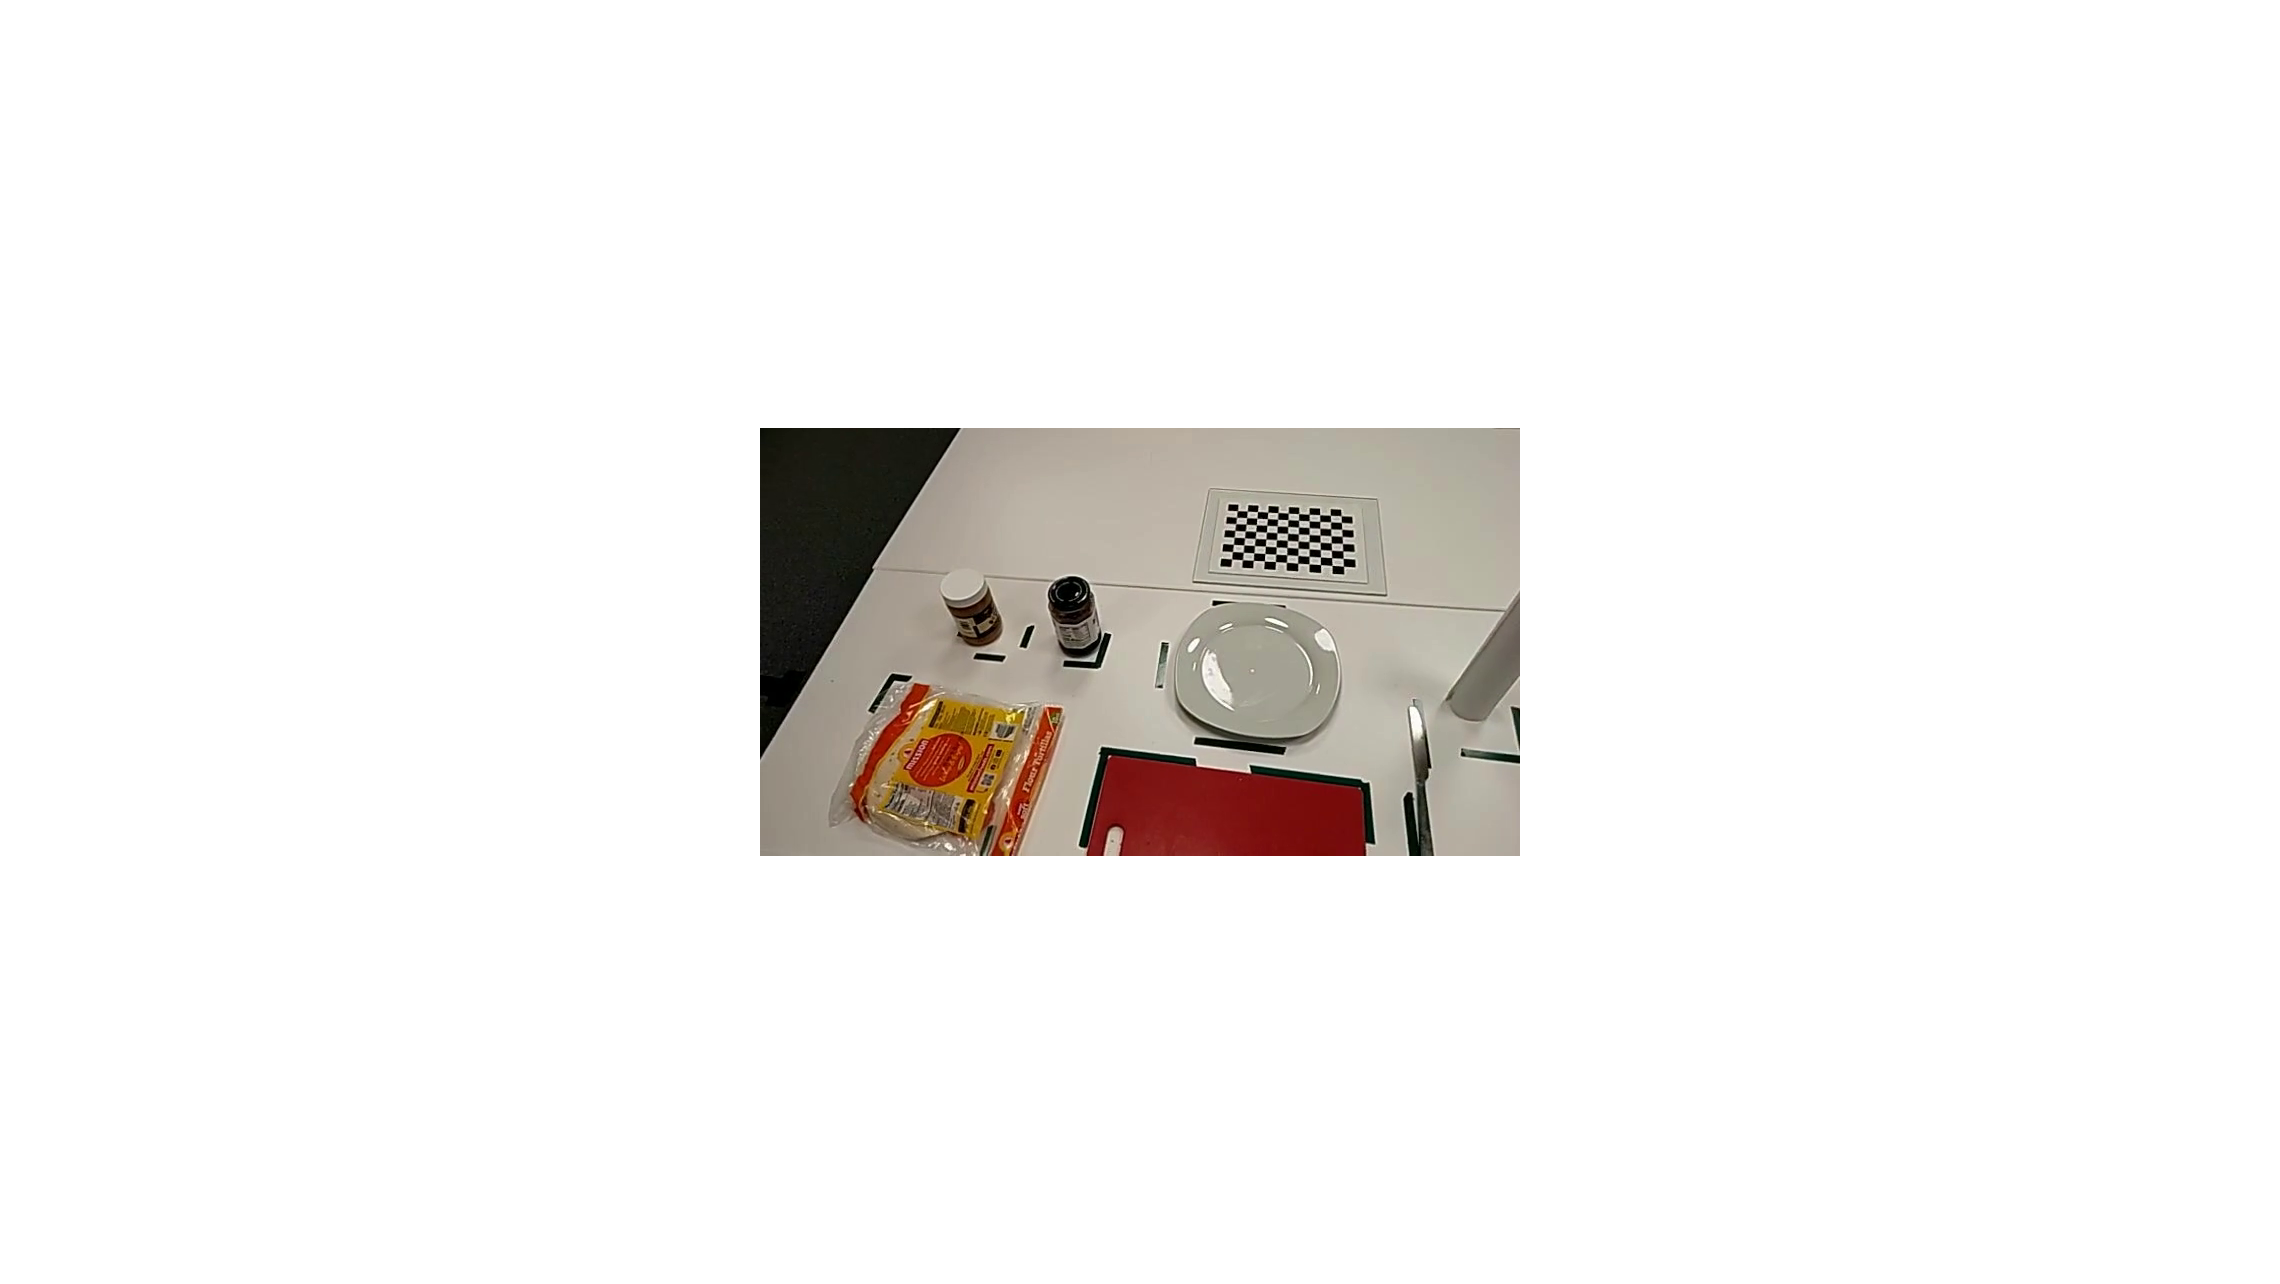

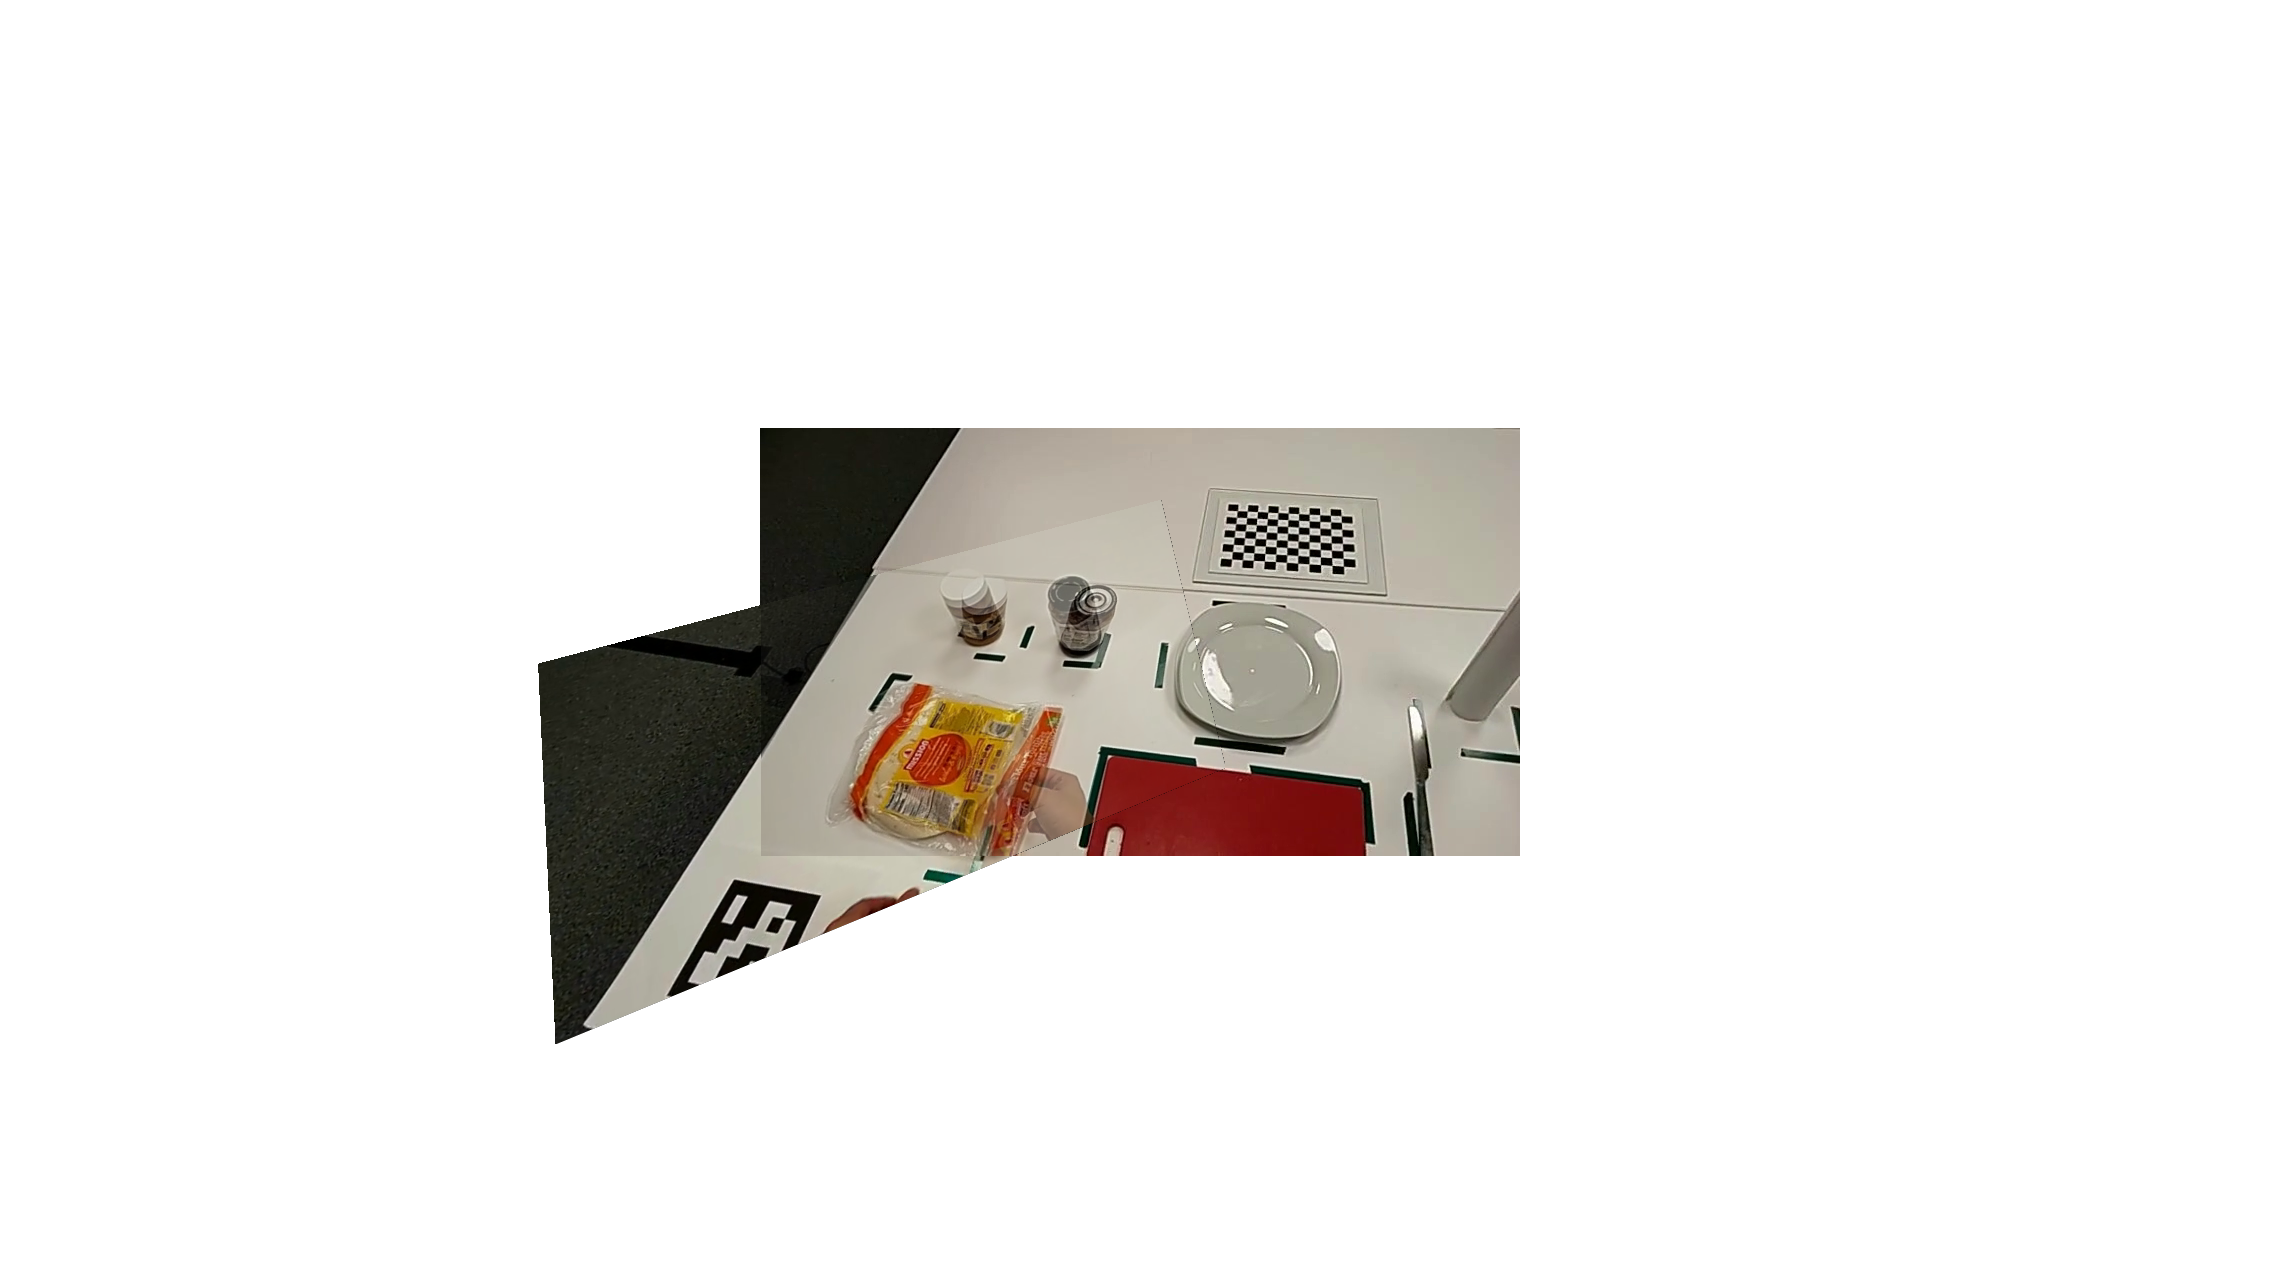

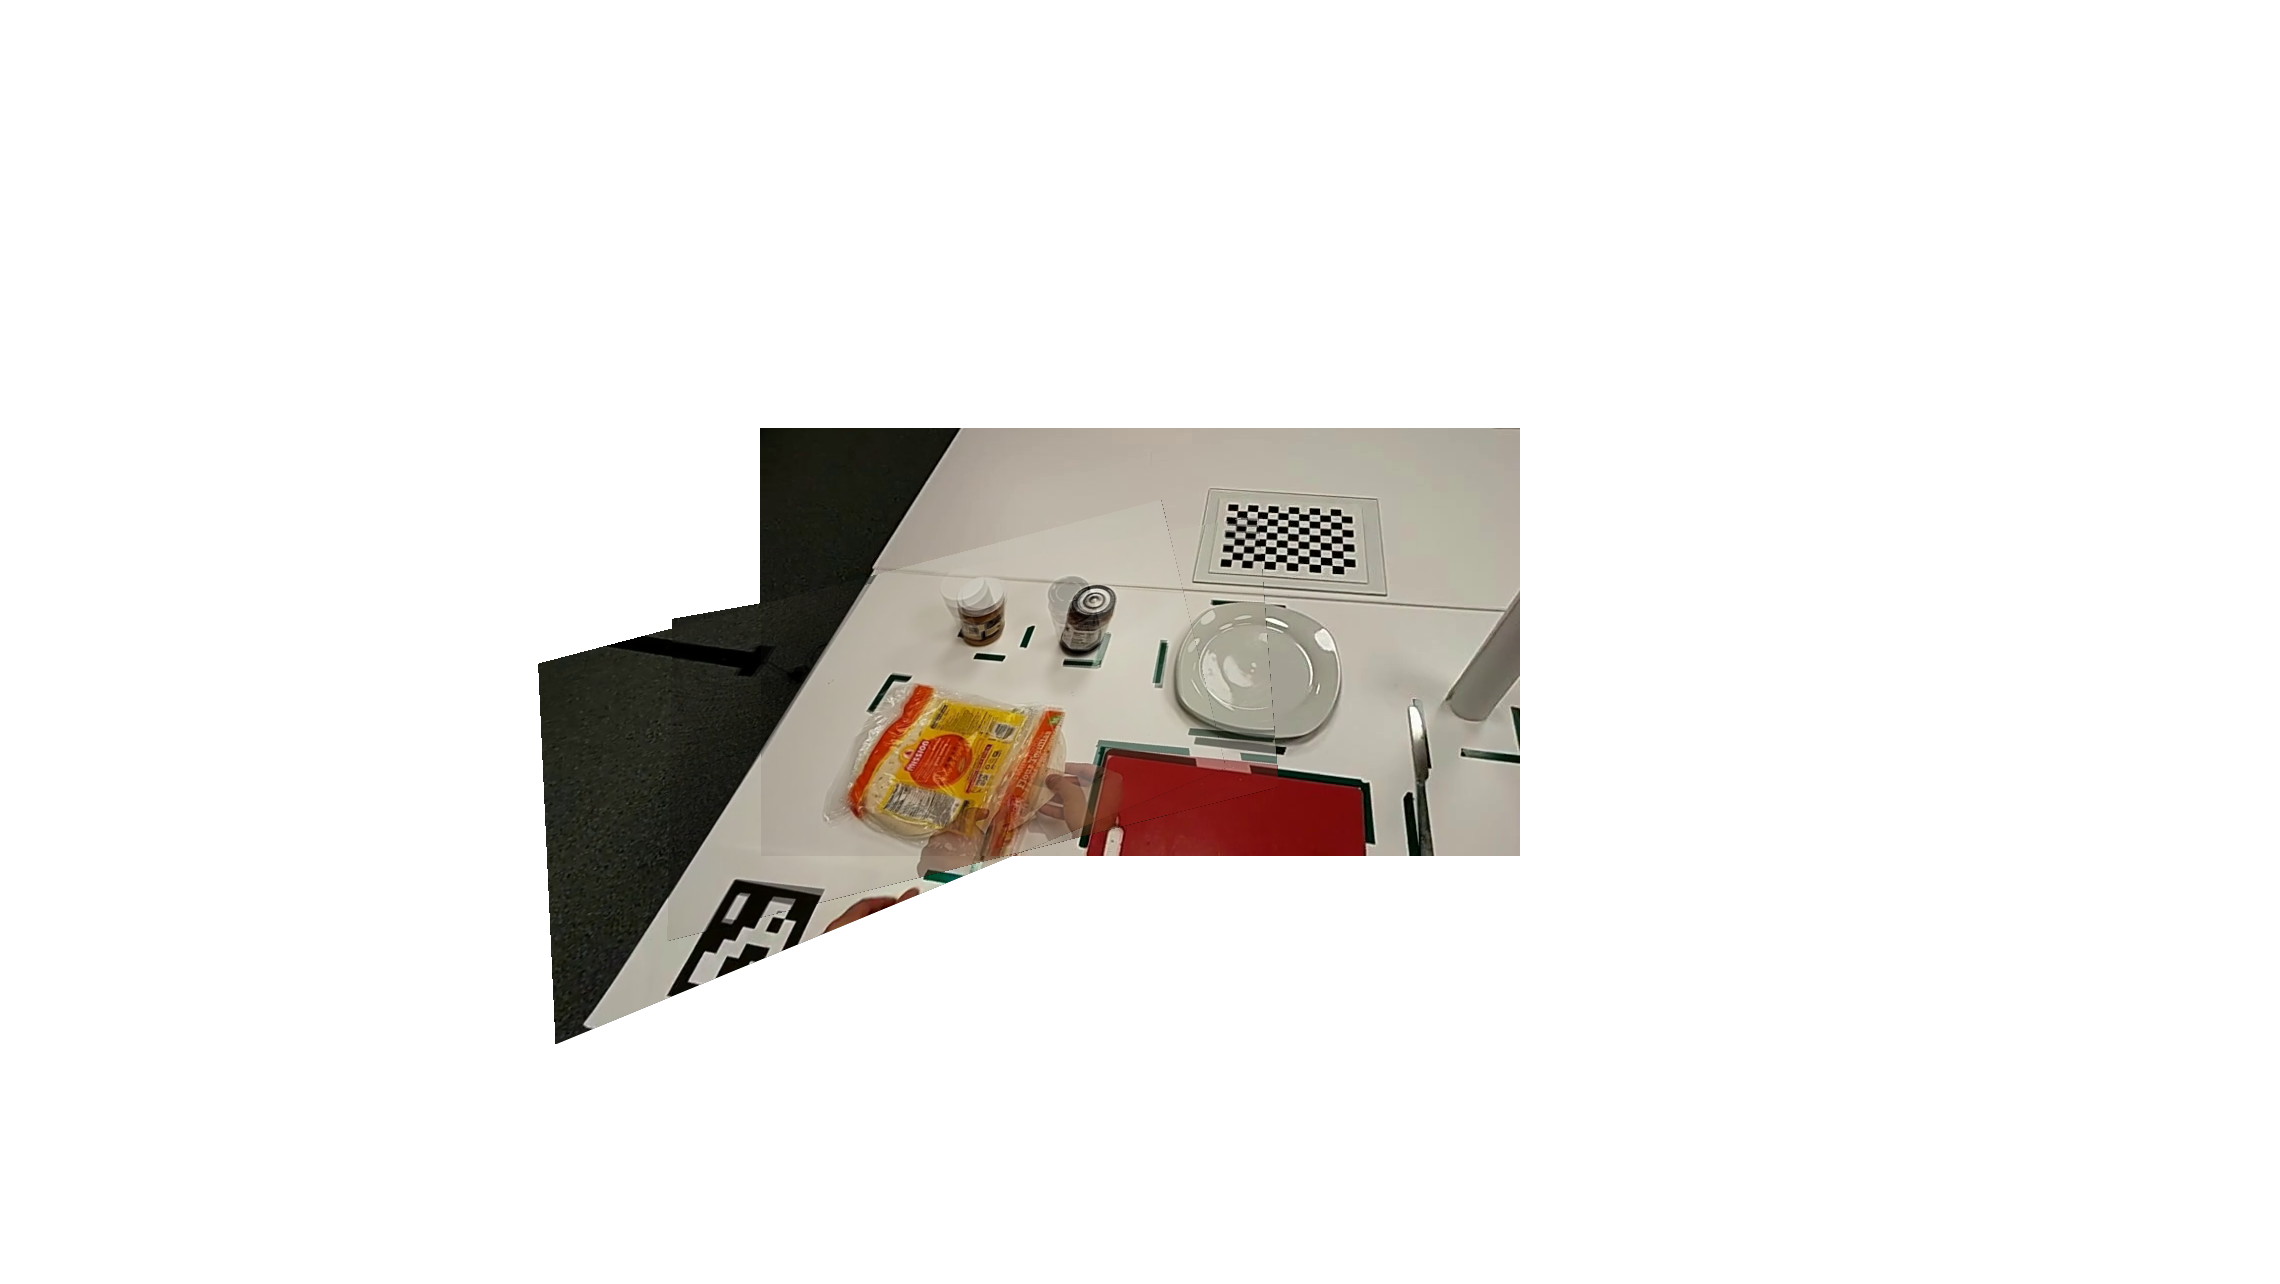

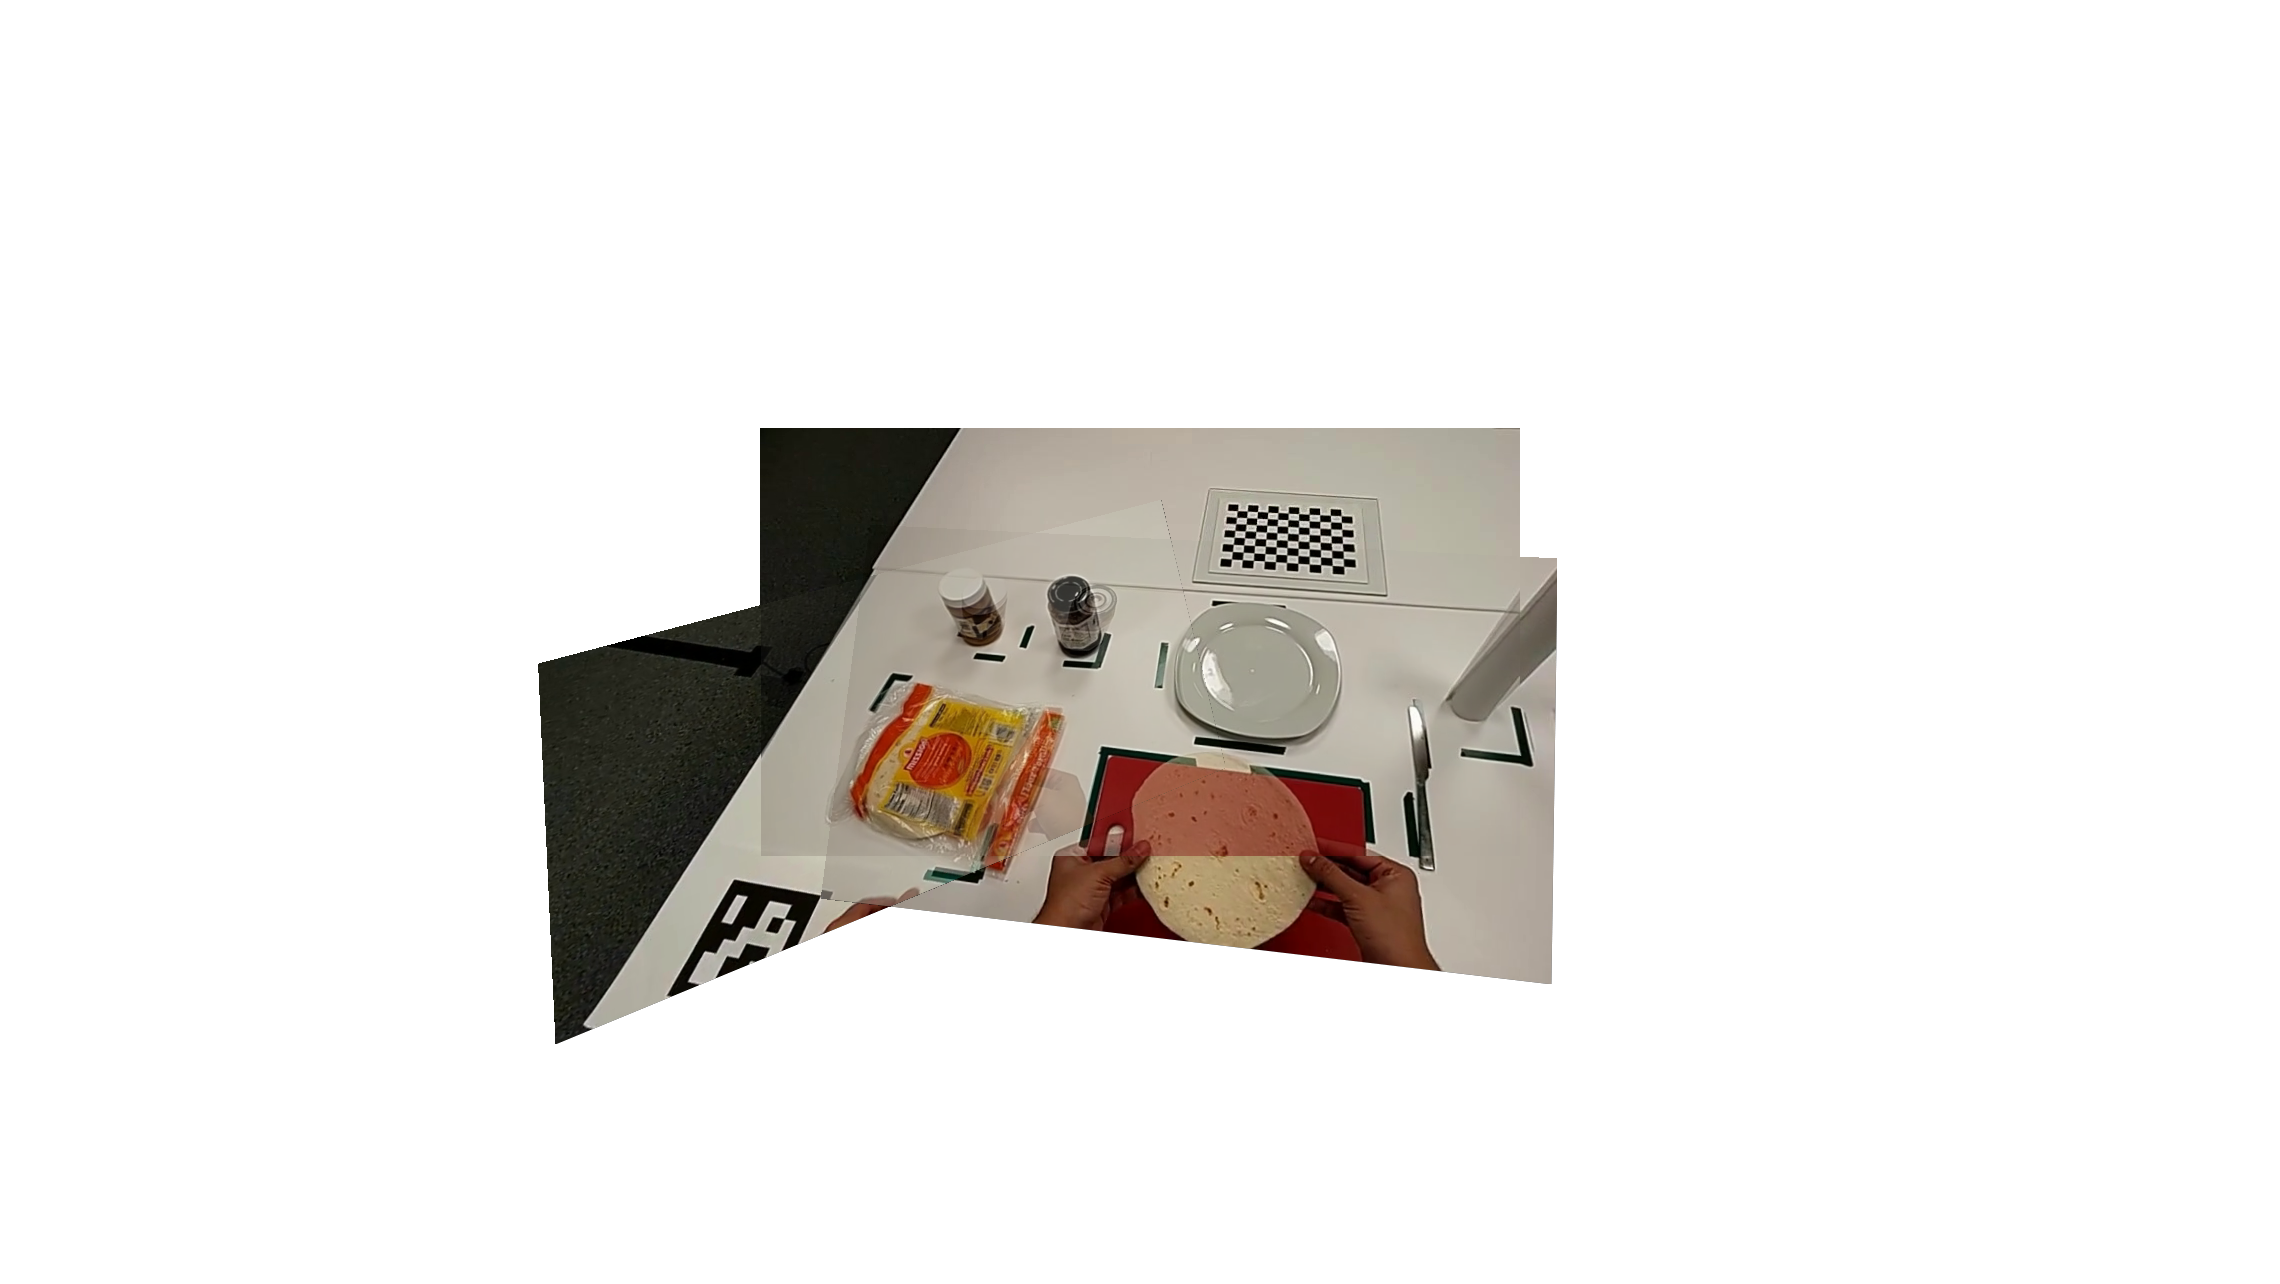

Function for warping the bounding boxes:

In [ ]:
"""

INPUTS:
index_list: array of indices of the frames in main_frame_arr frames used to create panorama_image [NOTE: this function will assume all frames were warped to the plane of the frame at the first index in index_list (aka the first one is dst)]
frames_timestamps_arr: array of timestamps corresponding to each frame used to create panorama_image
detic_dict: object detection model outputs
panorama_image: the panorama you want to draw bounding boxes on
new_transf_list: an array of the homography matrices used to create panorama_image (should be returned by warp_n_with_padding)
anchorX: the X translation used to create panorama_image (should be returned by warp_n_with_padding)
anchorY: the Y translation used to create panorama_image (should be returned by warp_n_with_padding)
colors_list: array of the bounding box colors for each timestep
thickness: thickness of bounding boxes (2 seems to be a reasonable default)

OUTPUTS:
image with bounding boxes for all objects at from given indices 

"""
def draw_all_bounding_boxes_for_given_indices(index_list, frames_timestamps_arr, detic_dict, panorama_image, new_transf_list, anchorX, anchorY, colors_list, thickness):

  image = panorama_image.copy() #so it doesn't draw directly on the panorama in case the one without bounding boxes is needed later

  for f in range(len(index_list)):
    if f == 0:
      index = next((i for i, obj in enumerate(detic_dict) if obj['timestamp'] == frames_timestamps_arr[index_list[f]]), -1)
      for i in range(len(detic_dict[index]["values"])):
          x = int(detic_dict[index]["values"][i]["xyxyn"][0] * 760)
          w = int(detic_dict[index]["values"][i]["xyxyn"][2] * 760)
          y = int(detic_dict[index]["values"][i]["xyxyn"][1] * 428)
          h = int(detic_dict[index]["values"][i]["xyxyn"][3] * 428)

          x = x + anchorX
          w = w + anchorX
          y = y + anchorY
          h = h + anchorY

          start_point = (x, y)
          end_point = (w, h)

          #draw object bounding box
          image = cv2.rectangle(image, start_point, end_point, colors_list[f], thickness)

          # Draw background rectangle
          image = cv2.rectangle(image, (x, y-15), (x + (w - x), y), colors_list[f], -1)

          # Add text
          image = cv2.putText(image, detic_dict[index]["values"][i]["label"], (x + 2,y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255,255,255, 255), 1)

    else:
      index = next((i for i, obj in enumerate(detic_dict) if obj['timestamp'] == frames_timestamps_arr[index_list[f]]), -1)
      for i in range(len(detic_dict[index]["values"])):
          x = int(detic_dict[index]["values"][i]["xyxyn"][0] * 760)
          w = int(detic_dict[index]["values"][i]["xyxyn"][2] * 760)
          y = int(detic_dict[index]["values"][i]["xyxyn"][1] * 428)
          h = int(detic_dict[index]["values"][i]["xyxyn"][3] * 428)

          x = warp_point(x, y, new_transf_list[f-1])[0]
          y = warp_point(x, y, new_transf_list[f-1])[1]
          w = warp_point(w, h, new_transf_list[f-1])[0]
          h = warp_point(w, h, new_transf_list[f-1])[1]

          start_point = (x, y)
          end_point = (w, h)
          
          #draw object bounding box
          image = cv2.rectangle(image, start_point, end_point, colors_list[f], thickness)

          # Draw red background rectangle
          image = cv2.rectangle(image, (x, y-15), (x + (w - x), y), colors_list[f], -1)

          # Add text
          image = cv2.putText(image, detic_dict[index]["values"][i]["label"], (x + 2,y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255,255,255, 255), 1)

  return image

Small example:

In [ ]:
main_frame_arr = video_to_frame_arr("/content/gdrive/MyDrive/2023.03.29-17.39.21-main.avi")

In [ ]:
with open("/content/2023.03.29-17.39.21-detic:image.json", 'r') as j:
     detic_dict = json.loads(j.read())

In [ ]:
#gets the # of seconds from start for each frame
frame_sfs_arr = []
sfs = 0
for i in range(len(main_frame_arr)):
  frame_sfs_arr.append(sfs)
  sfs = sfs + (1/15)

#have to match frames with timestamps (each frame needs to have a timestamp)
timestamps_sfs_arr = []
start_timestamp = detic_dict[0]["timestamp"]
for i in range(len(detic_dict)):
  current_timestamp = detic_dict[i]["timestamp"]
  sec_from_start = get_sec_from_start(current_timestamp, start_timestamp)
  timestamps_sfs_arr.append(sec_from_start)

frames_timestamps_arr = []
arr = timestamps_sfs_arr
n = len(arr)
for i in range(len(main_frame_arr)):
  target = frame_sfs_arr[i]
  closest = findClosest(arr, n, target)
  target_idx = timestamps_sfs_arr.index(closest)
  timestamp = detic_dict[target_idx]["timestamp"]
  frames_timestamps_arr.append(timestamp)

#stitch the panorama
src = main_frame_arr[160]
dst = main_frame_arr[200]
kp_src, des_src = get_keypoints_descriptors(src)
kp_dst, des_dst = get_keypoints_descriptors(dst)
matches = feature_matching(des_src, des_dst)
transf = get_homography_matrix(src, dst, kp_src, kp_dst, matches, 4)
src_list = [src]
transf_list = [transf]
dst_pad, warped_src_arr, new_transf_list, anchorX, anchorY = warp_n_with_padding(dst, src_list, transf_list, main_frame_arr)
im_arr = get_rgba_im_arr(dst_pad, warped_src_arr)
comp_arr = alpha_composite_n_images(im_arr)

Panorama looks like this:
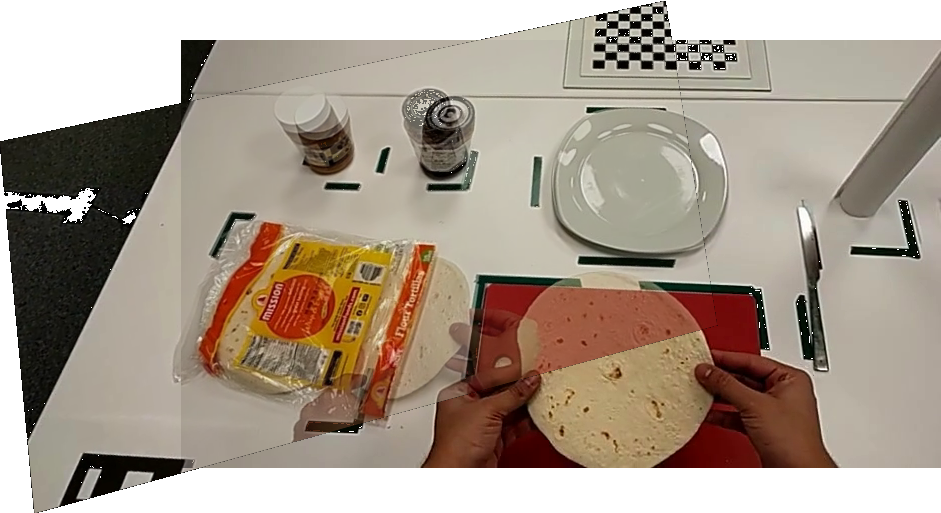

In [ ]:
#add bounding boxes
index_list = [200, 160]
frames_timestamps_arr = frames_timestamps_arr
detic_dict = detic_dict
panorama_image = comp_arr
new_transf_list = new_transf_list #list of homography matrices used to create panorama
anchorX = anchorX #anchorX and anchorY were calculated in the previous cell when generating the panorama
anchorY = anchorY
colors_list = [(0, 0, 255, 255), (0, 255, 0, 255)]
thickness = 2 

pano_with_bounding_boxes = draw_all_bounding_boxes_for_given_indices(index_list, frames_timestamps_arr, detic_dict, panorama_image, new_transf_list, anchorX, anchorY, colors_list, thickness)

With bounding boxes:

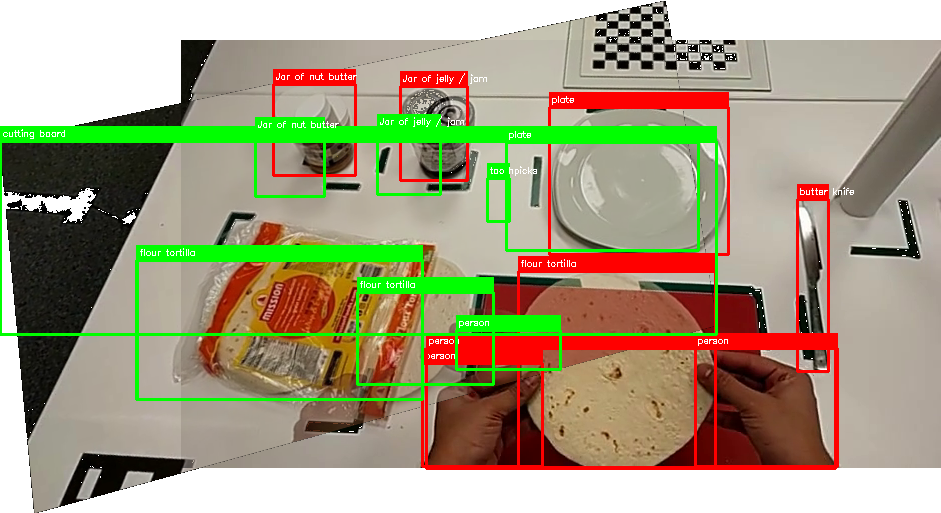

Note: the green bounding boxes aren't perfectly accurate, but I double checked and that is what the model output for that timestep. 